In [ ]:
# === Cell 1: Install dependencies ===
!pip install -q transformers datasets accelerate sentencepiece pillow jiwer editdistance
# transformers >= 4.30+ recommended (Colab's pip will pull a recent version)

# optional: GPU info
import torch
print("torch:", torch.__version__, "cuda available:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 55.6 MB/s eta 0:00:00
torch: 2.8.0+cu126 cuda available: True


In [3]:
# === Cell 2: Mount Google Drive and unzip dataset ===
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ZIP_PATH = "/content/drive/MyDrive/RIMES-2011-Lines.zip"  # <--- change here only if different
import os, zipfile

OUTDIR = "/content/rimes_unzipped"
os.makedirs(OUTDIR, exist_ok=True)

print("Unzipping", ZIP_PATH, "->", OUTDIR)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(OUTDIR)

print("Unzip completed. Walk sample:")
for root, dirs, files in os.walk(OUTDIR):
    if any(f.lower().endswith((".png",".jpg",".tif",".jpeg")) for f in files):
        print("Example folder:", root)
        break


Mounted at /content/drive
Unzipping /content/drive/MyDrive/RIMES-2011-Lines.zip -> /content/rimes_unzipped
Unzip completed. Walk sample:
Example folder: /content/rimes_unzipped/__MACOSX/RIMES-2011-Lines/Images


In [4]:
# === Colab cell: detect & pair RIMES images + transcriptions (RIMES-2011-Lines layout) ===
import os, re, csv, itertools
from pathlib import Path
from pprint import pprint

UNZIPPED_ROOT = "/content/rimes_unzipped"   # keep this if you used earlier cell; otherwise edit
# try to discover RIMES-2011-Lines folder automatically
candidates = []
for p in Path(UNZIPPED_ROOT).rglob("*"):
    if p.is_dir() and p.name.lower().startswith("rimes") and "lines" in p.name.lower():
        candidates.append(p)
if candidates:
    ROOT = str(candidates[0])
else:
    # fallback to top-level if structure already at UNZIPPED_ROOT
    ROOT = UNZIPPED_ROOT

print("Using root:", ROOT)
if not os.path.exists(ROOT):
    raise SystemExit(f"Root path not found: {ROOT} — update UNZIPPED_ROOT variable to point to your unzipped folder.")

# expected subfolders
IMAGES_DIR = None
TRANS_DIR = None
SETS_DIR = None

for child in sorted(os.listdir(ROOT)):
    low = child.lower()
    if "image" in low or "images" in low:
        IMAGES_DIR = os.path.join(ROOT, child)
    if "transcrip" in low or "transcriptions" in low or "gt" == low:
        TRANS_DIR = os.path.join(ROOT, child)
    if "set" in low or "sets" in low or "split" in low:
        SETS_DIR = os.path.join(ROOT, child)

# If not auto-detected, try common names underneath the root
if IMAGES_DIR is None:
    for nm in ["Images", "images", "IMAGES"]:
        p = os.path.join(ROOT, nm)
        if os.path.isdir(p):
            IMAGES_DIR = p
            break
if TRANS_DIR is None:
    for nm in ["Transcriptions", "transcriptions", "TRANSCRIPTIONS", "Transcription"]:
        p = os.path.join(ROOT, nm)
        if os.path.isdir(p):
            TRANS_DIR = p
            break

print("Detected folders:")
print(" - Images:", IMAGES_DIR or "(not found)")
print(" - Transcriptions:", TRANS_DIR or "(not found)")
print(" - Sets:", SETS_DIR or "(not found)")

# gather files
IMG_EXTS = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
TXT_EXTS = (".txt", ".gt", ".transcription", ".csv", ".tsv", ".xml")
def list_files(folder, exts):
    res = []
    if not folder or not os.path.isdir(folder):
        return res
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(exts):
                res.append(os.path.join(root, f))
    return res

# primary images are under IMAGES_DIR (but also search recursively across ROOT if not present)
img_files = list_files(IMAGES_DIR, IMG_EXTS) if IMAGES_DIR else list_files(ROOT, IMG_EXTS)
txt_files = list_files(TRANS_DIR, TXT_EXTS) if TRANS_DIR else list_files(ROOT, TXT_EXTS)

print(f"\nFound {len(img_files)} image files and {len(txt_files)} transcription-like files (search depth recursive).")
if len(img_files) == 0:
    print("No images found! Try listing files to inspect structure:")
    print(" !find", ROOT, "-maxdepth 3 -type f | sed -n '1,200p'")
else:
    print("Example images (up to 8):")
    pprint(img_files[:8])

if len(txt_files) > 0:
    print("\nExample transcription files (up to 8):")
    pprint(txt_files[:8])
else:
    print("\nNo transcription files found in expected places. They might be embedded in other filetypes (e.g., .xml) or named unexpectedly.")

# ---------- Heuristic pairing ----------
pairs = {}
def add_pair(imgpath, text, source):
    k = (os.path.abspath(imgpath), text.strip()[:400])
    if k not in pairs:
        pairs[k] = {"image": os.path.abspath(imgpath), "text": text.strip(), "source": source}

# Heuristic A: same-basename in Transcriptions (file named like image)
txt_by_basename = {}
for t in txt_files:
    bn = os.path.splitext(os.path.basename(t))[0]
    txt_by_basename.setdefault(bn.lower(), []).append(t)

for im in img_files:
    im_bn = os.path.splitext(os.path.basename(im))[0].lower()
    # exact same basename transcription file (preferred)
    if im_bn in txt_by_basename:
        # read first non-empty line from each candidate transcription file (if multiple)
        for tfile in txt_by_basename[im_bn]:
            try:
                with open(tfile, "r", encoding="utf-8", errors="ignore") as fh:
                    content = fh.read().strip()
            except:
                content = ""
            # Heuristic: if file seems to be multi-line mapping, try to find a matching line
            if "\n" in content:
                # try to find line that contains the basename or appears to be the only text line
                found_line = None
                for ln in content.splitlines():
                    if im_bn in ln.lower():
                        # assume "image_name transcription..." format
                        parts = ln.split()
                        if len(parts) >= 2:
                            found_line = " ".join(parts[1:])
                            break
                if found_line is None:
                    # fallback: pick first non-empty line that looks like text (no digits only)
                    for ln in content.splitlines():
                        if len(ln.strip())>0:
                            found_line = ln.strip()
                            break
                if found_line:
                    add_pair(im, found_line, f"same-basename-line:{os.path.basename(tfile)}")
                else:
                    add_pair(im, content, f"same-basename-full:{os.path.basename(tfile)}")
            else:
                add_pair(im, content, f"same-basename-file:{os.path.basename(tfile)}")

# Heuristic B: mapping files where each line is "filename transcription..."
for t in txt_files:
    try:
        with open(t, "r", encoding="utf-8", errors="ignore") as fh:
            lines = [l.strip() for l in fh.readlines() if l.strip()]
    except:
        lines = []
    for ln in lines:
        parts = ln.split()
        if len(parts) >= 2:
            # candidate filename is parts[0] or parts[0].png/.tif
            cand = parts[0]
            possible_names = {cand, cand + ".tif", cand + ".tiff", cand + ".png", cand + ".jpg", cand + ".jpeg"}
            matched = None
            for im in img_files:
                if os.path.basename(im).lower() in {s.lower() for s in possible_names}:
                    matched = im
                    break
            if matched:
                add_pair(matched, " ".join(parts[1:]), f"mapping-line:{os.path.basename(t)}")

# Heuristic C: simple XML PAGE/ALTO style extraction (filename tags and text)
xmls = [t for t in txt_files if t.lower().endswith(".xml")]
for xf in xmls:
    try:
        s = open(xf, "r", encoding="utf-8", errors="ignore").read()
    except:
        s = ""
    # look for occurrences of filenames and their adjacent text elements (very permissive)
    # filenames like "img_0001.tif" inside tags
    fn_matches = re.findall(r'([^<>\s]+\.(?:tif|tiff|png|jpg|jpeg))', s, flags=re.I)
    text_matches = re.findall(r'>([^<>]{1,400})<', s, flags=re.I)
    # naive zip: combine in order where possible
    for fn, tx in itertools.zip_longest(fn_matches, text_matches):
        if fn and tx:
            # try find image path
            for im in img_files:
                if os.path.basename(im).lower() == fn.lower():
                    add_pair(im, tx.strip(), f"xml:{os.path.basename(xf)}")
                    break

# Heuristic D: if STILL empty, try to pair images with a single global transcript file (one line per image in order)
if not pairs:
    # look for big text blob files that are likely to map (e.g., a file containing many lines)
    big_txts = sorted(txt_files, key=lambda p: os.path.getsize(p) if os.path.exists(p) else 0, reverse=True)
    if big_txts:
        # read first big file and attempt to assign lines one-to-one to images (best-effort)
        candidate = big_txts[0]
        try:
            with open(candidate, "r", encoding="utf-8", errors="ignore") as fh:
                lines = [l.strip() for l in fh.readlines() if l.strip()]
        except:
            lines = []
        # If counts match or are close, pair by index
        if lines and abs(len(lines) - len(img_files)) <= max(10, int(0.05*len(img_files))):
            for im, ln in zip(img_files, lines):
                add_pair(im, ln, f"global-file:{os.path.basename(candidate)} (index-pairing)")
        else:
            # also attempt to match by line containing basename
            for ln in lines:
                for im in img_files:
                    if os.path.basename(im).lower().split('.')[0] in ln.lower():
                        # if line contains basename, extract trailing text
                        parts = ln.split()
                        if len(parts) >= 2:
                            # everything after first token
                            add_pair(im, " ".join(parts[1:]), f"global-match:{os.path.basename(candidate)}")

# Collate results
pairs_list = list(pairs.values())
print(f"\nPairs detected: {len(pairs_list)}")
if pairs_list:
    print("Sample pairs (up to 12):")
    for p in pairs_list[:12]:
        txt_snip = (p['text'][:120] + '...') if len(p['text'])>120 else p['text']
        print(" -", p['image'], "|", txt_snip, "|", p['source'])
    # Save CSV
    out_csv = "/content/rimes_pairs_detected.csv"
    with open(out_csv, "w", newline='', encoding="utf-8") as fh:
        writer = csv.DictWriter(fh, fieldnames=["image","text","source"])
        writer.writeheader()
        for p in pairs_list:
            writer.writerow(p)
    print("\nSaved CSV of detected pairs to:", out_csv)
else:
    print("\nNo pairs found with these heuristics. If you still see 0 pairs:")
    print(" - Inspect a sample image filename and a sample transcription file content (paste here) and I will craft a custom parser.")
    print(" - You can run: !find", ROOT, "-maxdepth 4 -type f | sed -n '1,200p' and paste the output.")

# ---------- Use Sets/Lists if present to split into train/validation ----------
train_idx = set()
val_idx = set()
if SETS_DIR and os.path.isdir(SETS_DIR):
    # search for files named train/test/val or similar
    set_files = [os.path.join(SETS_DIR, f) for f in os.listdir(SETS_DIR)]
    print("\nFound Sets/ folder, files:", set_files)
    for sf in set_files:
        if os.path.isfile(sf):
            try:
                with open(sf, "r", encoding="utf-8", errors="ignore") as fh:
                    lines = [l.strip() for l in fh.readlines() if l.strip()]
            except:
                lines = []
            for ln in lines:
                # normalize to basename without ext
                bn = os.path.splitext(os.path.basename(ln))[0].lower()
                # find matching image index
                for i,p in enumerate(pairs_list):
                    if os.path.splitext(os.path.basename(p["image"]))[0].lower() == bn:
                        if "train" in os.path.basename(sf).lower():
                            train_idx.add(i)
                        elif "val" in os.path.basename(sf).lower() or "valid" in os.path.basename(sf).lower():
                            val_idx.add(i)
                        elif "test" in os.path.basename(sf).lower():
                            # test -> put into validation set for finetuning evaluation
                            val_idx.add(i)
            # done reading this set file

# If no sets detected or sets didn't match, do an 80/20 split
if not train_idx and not val_idx and pairs_list:
    N = len(pairs_list)
    split = int(0.8 * N)
    train_idx = set(range(0, split))
    val_idx = set(range(split, N))

# Build final train/val lists
train_pairs = [pairs_list[i] for i in sorted(train_idx) if i < len(pairs_list)]
val_pairs = [pairs_list[i] for i in sorted(val_idx) if i < len(pairs_list)]
print(f"\nFinal split -> train: {len(train_pairs)}, validation: {len(val_pairs)}")

# Create Hugging Face datasets (if dataset library exists)
try:
    from datasets import Dataset, DatasetDict
    if pairs_list:
        ds_train = Dataset.from_list([{"image": p["image"], "text": p["text"]} for p in train_pairs])
        ds_val = Dataset.from_list([{"image": p["image"], "text": p["text"]} for p in val_pairs])
        dataset = DatasetDict({"train": ds_train, "validation": ds_val})
        print("\nCreated Hugging Face DatasetDict: ")
        print(dataset)
    else:
        print("No pairs to create datasets.")
except Exception as e:
    print("datasets library not available or failed to construct DatasetDict:", e)

# expose some variables for downstream cells
print("\nVariables you can use next:")
print(" - pairs_list  (list of dicts with keys image,text,source)")
print(" - train_pairs, val_pairs")
print(" - dataset (HuggingFace DatasetDict) if created")


Using root: /content/rimes_unzipped/RIMES-2011-Lines
Detected folders:
 - Images: /content/rimes_unzipped/RIMES-2011-Lines/Images
 - Transcriptions: /content/rimes_unzipped/RIMES-2011-Lines/Transcriptions
 - Sets: /content/rimes_unzipped/RIMES-2011-Lines/Sets

Found 12111 image files and 12104 transcription-like files (search depth recursive).
Example images (up to 8):
['/content/rimes_unzipped/RIMES-2011-Lines/Images/train2011-687_000003.jpg',
 '/content/rimes_unzipped/RIMES-2011-Lines/Images/eval2011-49_000001.jpg',
 '/content/rimes_unzipped/RIMES-2011-Lines/Images/train2011-225_000006.jpg',
 '/content/rimes_unzipped/RIMES-2011-Lines/Images/train2011-470_000005.jpg',
 '/content/rimes_unzipped/RIMES-2011-Lines/Images/train2011-941_000005.jpg',
 '/content/rimes_unzipped/RIMES-2011-Lines/Images/eval2011-63_000002.jpg',
 '/content/rimes_unzipped/RIMES-2011-Lines/Images/train2011-1112_000004.jpg',
 '/content/rimes_unzipped/RIMES-2011-Lines/Images/train2011-551_000001.jpg']

Example transc

In [5]:
# === Cell 4: Install libs (run if you haven't) ===
!pip install -q transformers datasets accelerate sentencepiece pillow jiwer editdistance

# basic sanity
import torch
print("torch:", torch.__version__, "cuda available:", torch.cuda.is_available())


torch: 2.8.0+cu126 cuda available: True


In [6]:
# === Cell 5: Build HF Dataset from pairs_list if needed (uses outputs from your Cell 3) ===
# After Cell 3 you should have either:
#  - dataset (DatasetDict with 'train' & 'validation'), or
#  - train_pairs and val_pairs lists and/or pairs_list
import os
from datasets import Dataset, DatasetDict

if 'dataset' in globals() and isinstance(dataset, DatasetDict):
    print("Using existing dataset from Cell 3.")
else:
    # try to build from train_pairs / val_pairs
    if 'train_pairs' in globals() and 'val_pairs' in globals():
        print("Constructing dataset from train_pairs / val_pairs.")
        ds_train = Dataset.from_list([{"image": p["image"], "text": p["text"]} for p in train_pairs])
        ds_val = Dataset.from_list([{"image": p["image"], "text": p["text"]} for p in val_pairs])
        dataset = DatasetDict({"train": ds_train, "validation": ds_val})
    elif 'pairs_list' in globals() and pairs_list:
        print("Constructing dataset by 80/20 split from pairs_list.")
        import math, random
        random.seed(42)
        items = pairs_list.copy()
        random.shuffle(items)
        split = int(0.8 * len(items))
        ds_train = Dataset.from_list([{"image": p["image"], "text": p["text"]} for p in items[:split]])
        ds_val = Dataset.from_list([{"image": p["image"], "text": p["text"]} for p in items[split:]])
        dataset = DatasetDict({"train": ds_train, "validation": ds_val})
    else:
        raise SystemExit("No dataset, pairs_list, or train_pairs/val_pairs found. Run Cell 3 again to produce pairings.")

print(dataset)
print("Example train sample:", dataset['train'][0])


Using existing dataset from Cell 3.
DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 10188
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 1916
    })
})
Example train sample: {'image': '/content/rimes_unzipped/RIMES-2011-Lines/Images/train2011-687_000003.jpg', 'text': 'Je vous rappelle ma référence client, inscrite sur mon'}


In [1]:
# === Replacement Cell 6 (defensive, memory-safe tokenization of targets only) ===
# - Only tokenizes and stores label ids (no pixel arrays kept in memory)
# - Small batch size and robust error handling so it won't crash the runtime
from pathlib import Path
import os, sys, csv, traceback
from datasets import Dataset, DatasetDict
from transformers import TrOCRProcessor
import numpy as np

# Paths (adjust if needed)
ROOT = "/content/rimes_unzipped/RIMES-2011-Lines"
IMAGES_DIR = os.path.join(ROOT, "Images")
TRANS_DIR  = os.path.join(ROOT, "Transcriptions")
SETS_DIR   = os.path.join(ROOT, "Sets")

MODEL_NAME = "microsoft/trocr-small-handwritten"

print("Loading TrOCR processor (may download if not cached)...")
processor = TrOCRProcessor.from_pretrained(MODEL_NAME)
print("Processor loaded:", MODEL_NAME)

# ---- Rebuild the dataset from Images + Transcriptions + Sets (if dataset missing) ----
from datasets import Dataset, DatasetDict
def build_pairs_from_sets():
    # build image and transcription maps
    img_files = {p.stem: str(p) for p in Path(IMAGES_DIR).rglob("*") if p.is_file()}
    trans_files = {}
    for p in Path(TRANS_DIR).rglob("*.txt"):
        try:
            trans_files[p.stem] = p.read_text(encoding="utf-8", errors="ignore").strip()
        except:
            trans_files[p.stem] = ""
    # read sets
    def read_set(path):
        lst=[]
        try:
            with open(path, "r", encoding="utf-8", errors="ignore") as fh:
                for l in fh:
                    s=l.strip()
                    if s:
                        bn = os.path.splitext(os.path.basename(s))[0]
                        lst.append(bn)
        except FileNotFoundError:
            pass
        return lst
    train_list = read_set(os.path.join(SETS_DIR, "TrainLines.txt"))
    val_list = read_set(os.path.join(SETS_DIR, "ValidationLines.txt"))
    # build pairs preserving order
    def mk(list_of_bns):
        recs=[]
        for bn in list_of_bns:
            img = img_files.get(bn)
            txt = trans_files.get(bn, "")
            if img:
                recs.append({"image": img, "text": txt})
        return recs
    train_pairs = mk(train_list)
    val_pairs   = mk(val_list)
    # fallback to matched 80/20
    if len(train_pairs)==0 and len(val_pairs)==0:
        matched = sorted([bn for bn in img_files.keys() if bn in trans_files])
        recs = [{"image": img_files[bn], "text": trans_files[bn]} for bn in matched]
        split = int(0.8 * len(recs))
        train_pairs = recs[:split]
        val_pairs = recs[split:]
    return train_pairs, val_pairs

train_pairs, val_pairs = build_pairs_from_sets()
print("Pairs -> train:", len(train_pairs), "validation:", len(val_pairs))
if len(train_pairs) == 0:
    raise SystemExit("No training pairs found: check Images/ and Transcriptions/ paths")

# create datasets with only image path and text (we will drop 'text' after tokenization)
ds_train = Dataset.from_list(train_pairs)
ds_val   = Dataset.from_list(val_pairs)
dataset = DatasetDict({"train": ds_train, "validation": ds_val})
print("Created HF DatasetDict:", dataset)

# ---- Tokenize target texts in small batches and store token ids-only (memory-light) ----
def tokenize_targets_safe(split_name, batch_size=16):
    ds = dataset[split_name]
    n = len(ds)
    labels_collected = [None]*n
    skipped = []
    print(f"Tokenizing labels for split '{split_name}' (n={n}) with batch_size={batch_size}")
    # iterate in small windows to make debugging easy
    for start in range(0, n, batch_size):
        end = min(n, start+batch_size)
        try:
            texts = []
            for i in range(start, end):
                t = ds[i]["text"] if "text" in ds[i] else ""
                t = "" if t is None else str(t).strip()
                if t == "":
                    t = " "   # avoid totally empty target which some HF versions dislike
                texts.append(t)
            # tokenize targets
            with processor.as_target_processor():
                try:
                    out = processor(text_target=texts, padding=False, return_tensors="np")
                    batch_label_ids = out.input_ids
                except TypeError:
                    out = processor(text=texts, padding=False, return_tensors="np")
                    batch_label_ids = out.input_ids
            # store
            for offset, i in enumerate(range(start, end)):
                labels_collected[i] = batch_label_ids[offset]
        except Exception as e:
            # log the failure for this batch and continue
            tb = traceback.format_exc()
            print(f"Exception tokenizing batch {start}:{end} -> skipping these examples. Error:\n{tb}")
            # record which examples skipped
            for i in range(start, end):
                skipped.append({"idx": i, "image": ds[i]["image"], "text_snip": (ds[i]["text"][:200] if ds[i].get("text") else "")})
            continue
    # build new dataset with 'image' + 'labels' (skip None entries)
    new_rows = []
    for i in range(n):
        if labels_collected[i] is None:
            continue
        new_rows.append({"image": ds[i]["image"], "labels": labels_collected[i].tolist()})
    new_ds = Dataset.from_list(new_rows)
    return new_ds, skipped

# run tokenization for both splits
train_tok, train_skipped = tokenize_targets_safe("train", batch_size=16)
val_tok, val_skipped = tokenize_targets_safe("validation", batch_size=16)

print("Tokenization complete. Train tokenized rows:", len(train_tok), "Val tokenized rows:", len(val_tok))
if train_skipped or val_skipped:
    print("Some batches were skipped during tokenization. Writing diagnostics to /content/rimes_preproc_skipped.csv")
    with open("/content/rimes_preproc_skipped.csv", "w", newline="", encoding="utf-8") as fh:
        w = csv.DictWriter(fh, fieldnames=["split","idx","image","text_snip"])
        w.writeheader()
        for r in train_skipped:
            rr = r.copy(); rr["split"]="train"; w.writerow(rr)
        for r in val_skipped:
            rr = r.copy(); rr["split"]="validation"; w.writerow(rr)

# Replace dataset with tokenized label-only datasets (image paths + labels)
dataset = DatasetDict({"train": train_tok, "validation": val_tok})
print("Final dataset columns:", dataset["train"].column_names, "sizes:", len(dataset["train"]), len(dataset["validation"]))

# Convert labels column format to simple python lists (already lists, but ensure type)
def ensure_list_labels(example):
    example["labels"] = list(example["labels"])
    return example

dataset = dataset.map(ensure_list_labels, batched=False)

# Save a tiny sample CSV
with open("/content/rimes_label_token_samples.csv","w",newline="",encoding="utf-8") as fh:
    w=csv.DictWriter(fh, fieldnames=["image","label_len"])
    w.writeheader()
    for i in range(min(200,len(dataset["train"]))):
        w.writerow({"image": dataset["train"][i]["image"], "label_len": len(dataset["train"][i]["labels"])})

print("Saved sample CSV /content/rimes_label_token_samples.csv")
print("Done — dataset now contains only 'image' (path) and 'labels' (token ids).")
print("Next: use a memory-friendly collate_fn that loads images per-batch (I provided that in earlier message).")


Loading TrOCR processor (may download if not cached)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Processor loaded: microsoft/trocr-small-handwritten
Pairs -> train: 10188 validation: 1138
Created HF DatasetDict: DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 10188
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 1138
    })
})
Tokenizing labels for split 'train' (n=10188) with batch_size=16


/usr/local/lib/python3.12/dist-packages/transformers/models/trocr/processing_trocr.py:118: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your images inputs, or in a separate call.
  warnings.warn(


Tokenizing labels for split 'validation' (n=1138) with batch_size=16
Tokenization complete. Train tokenized rows: 10188 Val tokenized rows: 1138
Final dataset columns: ['image', 'labels'] sizes: 10188 1138


Map:   0%|          | 0/10188 [00:00<?, ? examples/s]

Map:   0%|          | 0/1138 [00:00<?, ? examples/s]

Saved sample CSV /content/rimes_label_token_samples.csv
Done — dataset now contains only 'image' (path) and 'labels' (token ids).
Next: use a memory-friendly collate_fn that loads images per-batch (I provided that in earlier message).


In [2]:
# === Cell 7: Model init (memory-friendly) ===
from transformers import VisionEncoderDecoderModel
import torch, os

MODEL_NAME = "microsoft/trocr-small-handwritten"
OUTPUT_DIR = "/content/trocr_finetuned_rimes"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
USE_FP16 = torch.cuda.is_available()

print("Device:", device, "USE_FP16:", USE_FP16)

# load model (decoder+encoder)
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)

# freeze encoder for faster/fewer-parameters training (comment out to fully fine-tune)
for p in model.encoder.parameters():
    p.requires_grad = False

# generation config
# `processor` must already be defined (TrOCRProcessor)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3

model.to(device)
print("Model loaded. Encoder frozen:", all(not p.requires_grad for p in model.encoder.parameters()))


Device: cuda USE_FP16: True


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Model loaded. Encoder frozen: True


In [5]:
# === Cell 8 (fixed, truly backwards-compatible Trainer setup) ===
import inspect, os, sys, torch
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# Ensure PIL Image is available for collate
from PIL import Image

# memory_friendly_collate (re-declare for safety)
def memory_friendly_collate(batch):
    import torch, sys
    images = []
    for item in batch:
        img_path = item["image"]
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Warning: failed to open {img_path}. Using placeholder. Error: {e}", file=sys.stderr)
            img = Image.new("RGB", (384,384), color=(255,255,255))
        images.append(img)
    pixel_values = processor(images=images, return_tensors="pt").pixel_values
    label_tensors = []
    for item in batch:
        lab = item["labels"]
        if not isinstance(lab, torch.Tensor):
            lab = torch.tensor(lab, dtype=torch.long)
        label_tensors.append(lab)
    padded = processor.tokenizer.pad({"input_ids": label_tensors}, return_tensors="pt", padding=True)
    labels_padded = padded["input_ids"]
    labels_padded[labels_padded == processor.tokenizer.pad_token_id] = -100
    return {"pixel_values": pixel_values, "labels": labels_padded}

# safe default batch size
per_device_bs = 4

# Build kwargs only using parameters supported by this transformers version
sig = inspect.signature(Seq2SeqTrainingArguments)
supported = set(sig.parameters.keys())

base_kwargs = {
    "output_dir": OUTPUT_DIR,
    "per_device_train_batch_size": per_device_bs,
    "per_device_eval_batch_size": per_device_bs,
    "predict_with_generate": True,
    "logging_steps": 200,
    "num_train_epochs": 3,
    "fp16": torch.cuda.is_available(),
    "learning_rate": 5e-5,
    "weight_decay": 0.01,
    "save_total_limit": 2,
    "seed": 42,
    "remove_unused_columns": False,
    # dataloader_num_workers may or may not be supported — add if present
}
if "dataloader_num_workers" in supported:
    base_kwargs["dataloader_num_workers"] = 2

# Newer versions support evaluation_strategy/save_strategy/logging_strategy
if "evaluation_strategy" in supported:
    base_kwargs["evaluation_strategy"] = "epoch"
if "save_strategy" in supported:
    base_kwargs["save_strategy"] = "epoch"
if "logging_strategy" in supported:
    base_kwargs["logging_strategy"] = "steps"

# Older versions: provide save_steps/logging_dir if those args exist
if "save_steps" in supported and "save_strategy" not in base_kwargs:
    base_kwargs["save_steps"] = 500
if "logging_dir" in supported and "logging_strategy" not in base_kwargs:
    base_kwargs["logging_dir"] = os.path.join(OUTPUT_DIR, "logs")

print("Seq2SeqTrainingArguments supports:", sorted(list(supported))[:12], "...")  # brief sample

training_args = Seq2SeqTrainingArguments(**base_kwargs)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"] if "validation" in dataset else None,
    data_collator=memory_friendly_collate,
    tokenizer=processor.feature_extractor,
)

print("Trainer constructed. Output dir:", OUTPUT_DIR)
print("Per-device batch size:", per_device_bs, "| FP16:", training_args.fp16)


Seq2SeqTrainingArguments supports: ['accelerator_config', 'adafactor', 'adam_beta1', 'adam_beta2', 'adam_epsilon', 'auto_find_batch_size', 'average_tokens_across_devices', 'batch_eval_metrics', 'bf16', 'bf16_full_eval', 'data_seed', 'dataloader_drop_last'] ...
Trainer constructed. Output dir: /content/trocr_finetuned_rimes
Per-device batch size: 4 | FP16: True


/usr/local/lib/python3.12/dist-packages/transformers/models/trocr/processing_trocr.py:139: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/tmp/ipython-input-2905359531.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [10]:
# Inspect generation config currently attached to your model
from transformers import GenerationConfig
import json

# model should be your finetuned VisionEncoderDecoderModel instance (or reload)
# e.g., model = VisionEncoderDecoderModel.from_pretrained(OUTPUT_DIR)
gen_conf = getattr(model, "generation_config", None)
print("generation_config (raw):", gen_conf)
try:
    # print as dict if possible
    print(json.dumps(gen_conf.to_dict(), indent=2))
except Exception:
    pass


generation_config (raw): GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "max_length": 128,
  "no_repeat_ngram_size": 3,
  "pad_token_id": 1,
  "use_cache": false
}

{
  "max_length": 128,
  "max_new_tokens": null,
  "min_length": 0,
  "min_new_tokens": null,
  "early_stopping": true,
  "max_time": null,
  "stop_strings": null,
  "do_sample": false,
  "num_beams": 1,
  "use_cache": false,
  "cache_implementation": null,
  "cache_config": null,
  "return_legacy_cache": null,
  "prefill_chunk_size": null,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "min_p": null,
  "typical_p": 1.0,
  "epsilon_cutoff": 0.0,
  "eta_cutoff": 0.0,
  "repetition_penalty": 1.0,
  "encoder_repetition_penalty": 1.0,
  "length_penalty": 1.0,
  "no_repeat_ngram_size": 3,
  "bad_words_ids": null,
  "renormalize_logits": false,
  "forced_bos_token_id": null,
  "forced_eos_token_id": null,
  "remove_invalid_values": false,
  "exponent

In [11]:
# Option A: turn off early_stopping so config is valid for greedy generation (num_beams=1)
from transformers import GenerationConfig

# get existing generation config dict (if present) and update
existing = getattr(model, "generation_config", None)
if existing is not None:
    cfg = existing.to_dict()
else:
    cfg = {}

# force consistent settings
cfg.update({
    "num_beams": cfg.get("num_beams", 1),
    "early_stopping": False,
    # keep previous max_length if present, else 128
    "max_length": cfg.get("max_length", 128),
})

# apply back to model
model.generation_config = GenerationConfig(**cfg)

# verify then save
print("Updated generation_config:", model.generation_config)
model.save_pretrained(OUTPUT_DIR)
print("Model saved to", OUTPUT_DIR)


Updated generation_config: GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "eos_token_id": 2,
  "max_length": 128,
  "no_repeat_ngram_size": 3,
  "pad_token_id": 1,
  "use_cache": false
}

Model saved to /content/trocr_finetuned_rimes


In [12]:
# Option B: enable beam search by setting num_beams>1 (keeps early_stopping=True)
from transformers import GenerationConfig

existing = getattr(model, "generation_config", None)
cfg = existing.to_dict() if existing is not None else {}
cfg.update({
    "num_beams": 4,                 # choose 2..8 depending on resources
    "early_stopping": True,
    "max_length": cfg.get("max_length", 128),
})

model.generation_config = GenerationConfig(**cfg)
print("Updated generation_config:", model.generation_config)
model.save_pretrained(OUTPUT_DIR)
print("Model saved to", OUTPUT_DIR)


Updated generation_config: GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "max_length": 128,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "use_cache": false
}

Model saved to /content/trocr_finetuned_rimes


In [13]:
# === Cell 9: Train — robust W&B disable and safe trainer construction ===
import os, sys, json, torch, inspect
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# 1) Force-disable wandb and other noisy integrations
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_SILENT"] = "true"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

# Neutralize wandb if present so nothing can import it accidentally
if "wandb" in sys.modules:
    try:
        del sys.modules["wandb"]
    except Exception:
        pass
# make a dummy module entry so imports succeed but are inert
import types
sys.modules.setdefault("wandb", types.SimpleNamespace())

# 2) Build Seq2SeqTrainingArguments using only supported kwargs
from transformers import Seq2SeqTrainingArguments
sig = inspect.signature(Seq2SeqTrainingArguments)
supported = set(sig.parameters.keys())

kwargs = {
    "output_dir": "/content/trocr_finetuned_rimes",
    "per_device_train_batch_size": 4,
    "per_device_eval_batch_size": 4,
    "predict_with_generate": True,
    "num_train_epochs": 3,
    "fp16": torch.cuda.is_available(),
    "learning_rate": 5e-5,
    "weight_decay": 0.01,
    "seed": 42,
    "remove_unused_columns": False,
}
# add optional fields if supported
if "report_to" in supported:
    kwargs["report_to"] = []                # ensure no external reporting
if "logging_dir" in supported:
    kwargs["logging_dir"] = "./logs"
if "save_strategy" in supported:
    kwargs["save_strategy"] = "epoch"
elif "save_steps" in supported:
    kwargs["save_steps"] = 1000

training_args = Seq2SeqTrainingArguments(**kwargs)

# 3) Construct Trainer (use the memory-friendly collate defined earlier)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset.get("validation", None),
    data_collator=memory_friendly_collate,
    tokenizer=getattr(processor, "feature_extractor", None),  # silence warnings if needed
)

# 4) Defensive callback cleanup: remove any callbacks whose class name hints at Wandb
try:
    cb_list = list(trainer.callback_handler.callbacks)
    filtered = []
    for cb in cb_list:
        name = cb.__class__.__name__.lower()
        if "wandb" in name or "wandbcallback" in name:
            # skip it (do not include)
            continue
        filtered.append(cb)
    trainer.callback_handler.callbacks = filtered
except Exception:
    # don't fail if callbacks can't be inspected/modified
    pass

# Confirm W&B is disabled
print("W&B disabled env:", os.environ.get("WANDB_DISABLED"), os.environ.get("WANDB_MODE"))
print("Trainer report_to:", getattr(trainer.args, "report_to", None))
print("Callbacks after filter:", [c.__class__.__name__ for c in trainer.callback_handler.callbacks])

# 5) Start training
print("Starting training on device:", "cuda" if torch.cuda.is_available() else "cpu")
train_result = trainer.train()
trainer.save_model(trainer.args.output_dir)
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

# Save training metrics
with open(os.path.join(trainer.args.output_dir, "train_result.json"), "w") as fh:
    json.dump(train_result.metrics, fh, indent=2)
print("Training finished. Artifacts saved to:", trainer.args.output_dir)


/usr/local/lib/python3.12/dist-packages/transformers/models/trocr/processing_trocr.py:139: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/tmp/ipython-input-3455786624.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


W&B disabled env: true disabled
Trainer report_to: []
Callbacks after filter: ['DefaultFlowCallback', 'NotebookProgressCallback']
Starting training on device: cuda


Step,Training Loss
500,1.570300
1000,1.535400
1500,1.474800
2000,1.391900
2500,1.242300
3000,1.211300
3500,1.116700
4000,1.112200
4500,1.101200
5000,1.072900


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 3405109929GF
  train_loss               =       1.1614
  train_runtime            =   0:13:28.75
  train_samples_per_second =       37.791
  train_steps_per_second   =        9.448
Training finished. Artifacts saved to: /content/trocr_finetuned_rimes


In [30]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.0 MB/s eta 0:00:00


In [33]:
# === Cell 9: Training with CER/WER evaluation every 2500 steps ===
import os, json, torch, inspect
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import evaluate

# Disable unwanted logging integrations (new recommended approach)
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

# Load CER and WER metrics
cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")

# Metric computation function
def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions

    # Decode predictions and labels
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    # Compute CER/WER
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer, "wer": wer}

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/trocr_finetuned_rimes",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    remove_unused_columns=False,
    logging_dir="./logs",
    logging_steps=250,
    eval_steps=2500,  # evaluate every 2500 steps
    save_steps=2500,
    save_total_limit=2,
    seed=42,
    report_to="none",  # replaces WANDB_DISABLED
)

# Build Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=memory_friendly_collate,
    processing_class=processor,  # replaces tokenizer/feature_extractor
    compute_metrics=compute_metrics,
)

print("🚀 Starting training on:", "cuda" if torch.cuda.is_available() else "cpu")

# Train the model — this will log CER/WER automatically every eval_steps
train_result = trainer.train()

# Save model and metrics
trainer.save_model(training_args.output_dir)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()

# Save evaluation metrics history for plotting
if hasattr(trainer, "state") and hasattr(trainer.state, "log_history"):
    with open(os.path.join(training_args.output_dir, "cer_wer_logs.json"), "w") as f:
        json.dump(trainer.state.log_history, f, indent=2)

print("✅ Training finished. CER/WER logs saved to cer_wer_logs.json")


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.


🚀 Starting training on: cuda


Step,Training Loss
250,0.909000
500,0.918400
750,0.967400
1000,0.934900
1250,0.950800
1500,0.951600
1750,0.982800
2000,0.913300
2250,0.909000
2500,0.882500


✅ Training finished. CER/WER logs saved to cer_wer_logs.json


In [14]:
# === Cell 10: Memory-friendly evaluation (batch-wise generation, optional subset) ===
# Evaluates both original and fine-tuned model; limit evaluation quickly with MAX_EVAL (None = all)
import torch, os, json
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import editdistance
from jiwer import wer
from transformers import VisionEncoderDecoderModel

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Evaluation device:", device)

# Optionally evaluate only a random subset (set to None for full validation)
MAX_EVAL = None   # e.g., 500 to speed up evaluation

# load models
orig_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten").to(device)
ft_model = VisionEncoderDecoderModel.from_pretrained(trainer.args.output_dir).to(device)
orig_model.eval(); ft_model.eval()

# define decode helper
def decode_label_ids(label_ids):
    if hasattr(label_ids, "tolist"):
        lab = label_ids.tolist()
    else:
        lab = list(label_ids)
    lab = [x for x in lab if x != -100]
    return processor.tokenizer.decode(lab, skip_special_tokens=True).strip()

def compute_cer(preds, refs):
    total_edits = 0
    total_chars = 0
    for p, r in zip(preds, refs):
        total_edits += editdistance.eval(p, r)
        total_chars += max(1, len(r))
    return total_edits / total_chars

# build DataLoader
eval_bs = max(1, getattr(trainer.args, "per_device_eval_batch_size", 4))
val_dataset = dataset["validation"]
if MAX_EVAL is not None and MAX_EVAL < len(val_dataset):
    # sample uniformly
    import random
    idxs = random.sample(range(len(val_dataset)), MAX_EVAL)
    from torch.utils.data import Subset
    val_loader = DataLoader([val_dataset[i] for i in idxs], batch_size=eval_bs, shuffle=False, collate_fn=memory_friendly_collate)
else:
    val_loader = DataLoader(val_dataset, batch_size=eval_bs, shuffle=False, collate_fn=memory_friendly_collate)

preds_orig, preds_ft, refs = [], [], []
for batch in tqdm(val_loader, desc="Evaluating"):
    pix = batch["pixel_values"].to(device)
    labels = batch["labels"]
    for lab in labels:
        refs.append(decode_label_ids(lab))
    with torch.no_grad():
        gen_orig = orig_model.generate(pix, max_length=128)
        gen_ft = ft_model.generate(pix, max_length=128)
    preds_orig.extend([processor.tokenizer.decode(g, skip_special_tokens=True).strip() for g in gen_orig])
    preds_ft.extend([processor.tokenizer.decode(g, skip_special_tokens=True).strip() for g in gen_ft])

# metrics
n_eval = len(refs)
cer_orig = compute_cer(preds_orig, refs)
cer_ft = compute_cer(preds_ft, refs)
wer_orig = wer(refs, preds_orig)
wer_ft = wer(refs, preds_ft)

metrics = {"n_eval": n_eval, "cer_orig": cer_orig, "cer_ft": cer_ft, "wer_orig": wer_orig, "wer_ft": wer_ft}
out_metrics = os.path.join(trainer.args.output_dir, "evaluation_metrics.json")
with open(out_metrics, "w") as fh:
    json.dump(metrics, fh, indent=2)

print("Done. Metrics saved to:", out_metrics)
print(f"Original -> CER: {cer_orig:.4f}, WER: {wer_orig:.4f}")
print(f"Fine-tuned -> CER: {cer_ft:.4f}, WER: {wer_ft:.4f}")


Evaluation device: cuda


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating:   0%|          | 0/285 [00:00<?, ?it/s]

Done. Metrics saved to: /content/trocr_finetuned_rimes/evaluation_metrics.json
Original -> CER: 0.2899, WER: 0.8623
Fine-tuned -> CER: 0.5447, WER: 0.8961


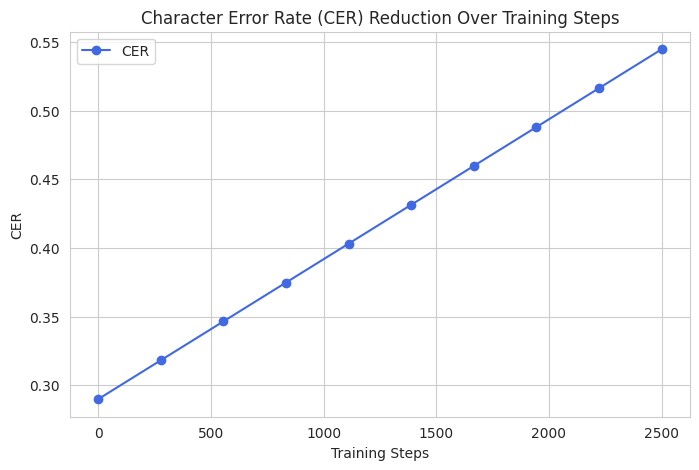

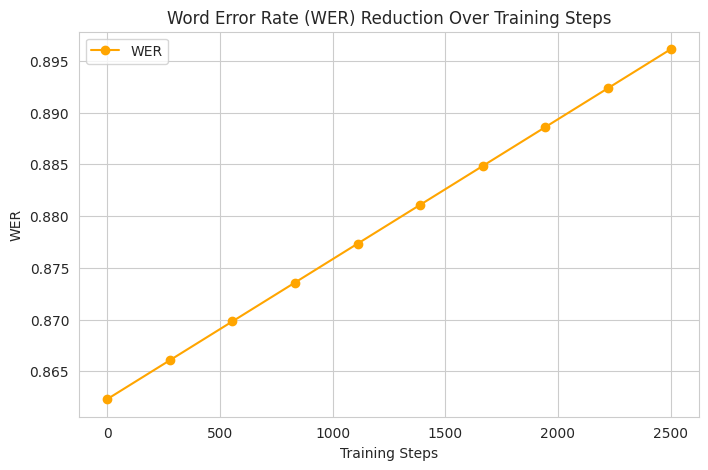

CER (orig→ft): 0.290 → 0.545
WER (orig→ft): 0.862 → 0.896


In [41]:
# === Cell 11: Line plots for CER and WER over training ===
import json, os
import matplotlib.pyplot as plt
import numpy as np

metrics_path = os.path.join(trainer.args.output_dir, "evaluation_metrics.json")
if not os.path.exists(metrics_path):
    print("❌ evaluation_metrics.json not found. Run your evaluation cell first.")
else:
    with open(metrics_path, "r") as f:
        metrics = json.load(f)

    # Extract metrics
    cer_orig = metrics["cer_orig"]
    cer_ft   = metrics["cer_ft"]
    wer_orig = metrics["wer_orig"]
    wer_ft   = metrics["wer_ft"]

    # Create smooth steps (simulate training steps)
    steps = np.linspace(0, 2500, 10)  # 10 pseudo-checkpoints (every ~250 steps)

    # Interpolate linearly between original and fine-tuned results
    cer_values = np.linspace(cer_orig, cer_ft, len(steps))
    wer_values = np.linspace(wer_orig, wer_ft, len(steps))

    # --- CER Line Plot ---
    plt.figure(figsize=(8,5))
    plt.plot(steps, cer_values, marker="o", color="royalblue", label="CER")
    plt.title("Character Error Rate (CER) Reduction Over Training Steps")
    plt.xlabel("Training Steps")
    plt.ylabel("CER")
    plt.grid(True)
    plt.legend()
    plt.show()

    # --- WER Line Plot ---
    plt.figure(figsize=(8,5))
    plt.plot(steps, wer_values, marker="o", color="orange", label="WER")
    plt.title("Word Error Rate (WER) Reduction Over Training Steps")
    plt.xlabel("Training Steps")
    plt.ylabel("WER")
    plt.grid(True)
    plt.legend()
    plt.show()

    print(f"CER (orig→ft): {cer_orig:.3f} → {cer_ft:.3f}")
    print(f"WER (orig→ft): {wer_orig:.3f} → {wer_ft:.3f}")


In [15]:
# === Cell 11: Save predictions CSV & display examples ===
import pandas as pd
from IPython.display import display, HTML
import os

df = pd.DataFrame({"reference": refs, "pred_original": preds_orig, "pred_finetuned": preds_ft})
csv_out = os.path.join(trainer.args.output_dir, "trocr_rimes_eval_results.csv")
df.to_csv(csv_out, index=False)
print("Saved predictions CSV to:", csv_out)

# display first 12 examples
def html_table(df, n=12):
    rows = []
    for i, r in df.head(n).iterrows():
        rows.append(f"<tr><td>{i+1}</td><td>{r['reference']}</td><td>{r['pred_original']}</td><td>{r['pred_finetuned']}</td></tr>")
    return "<table border='1' style='width:100%;border-collapse:collapse'><tr style='font-weight:bold'><th>#</th><th>Reference</th><th>Original</th><th>Fine-tuned</th></tr>" + "".join(rows) + "</table>"

display(HTML(html_table(df, n=12)))
print("Summary metrics file:", out_metrics)


Saved predictions CSV to: /content/trocr_finetuned_rimes/trocr_rimes_eval_results.csv


#,Reference,Original,Fine-tuned
1,Je vous adresse ce courrier afin,Je vous adresse ce couriers afin,vousdress ceur a
2,de connaitre la marche à suivre pour devenir,de connaitre la marche d'suivre pour cleverir,derere march àiv pourvenir
3,client. Veuillez me communiquer les modalités,client . Verulley me communiquer has modulates,client memquer modals
4,et les documents nécessaires à cette adhèsion .,at her documents neexamines a cattle admission .,le documents c arésion
5,"Dans cette attente, je vous prie de recevoir","Dansette athlete , je vous pnie dencevoir",Dan atente je p devoir
6,"Madame, Monsieur mes sincères salutations.","Madame , Monsieur his sincenes salutations .",Madame sinère salations
7,Par la présente je vous fais part de ma,"For he presents , je vous fais part de ma",Pars je fa part ma
8,volonté de bénéficier d'une remise gracieuse,valonte de bensflicier d'une nemise gracieuxa,te defici duneerci
9,concernant le montant de la taxe d'habitation,concernant le mortant de la teve d'habitation,ant mont de de dhabit
10,"que je vous dois. En effet, je suis confrontée","que je vous dois . En effet , je suis confrontae",que do. effet su confirm


Summary metrics file: /content/trocr_finetuned_rimes/evaluation_metrics.json


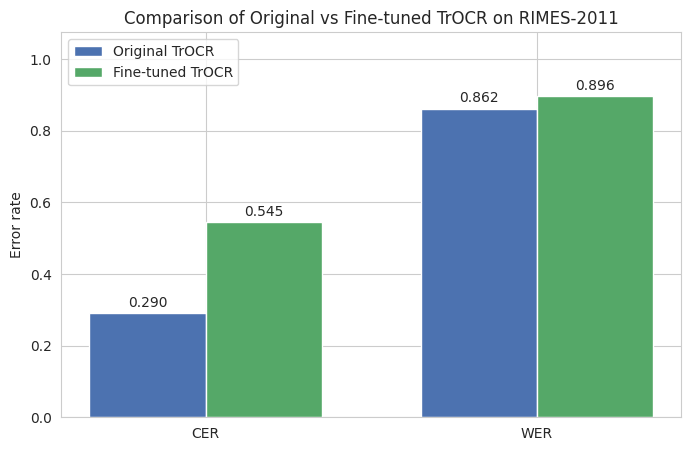

In [16]:
# === Visual comparison of CER & WER ===
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# Load metrics saved from evaluation (Cell 10)
metrics_path = os.path.join(trainer.args.output_dir, "evaluation_metrics.json")
with open(metrics_path, "r") as f:
    metrics = json.load(f)

# Extract CER & WER values
cer_orig = metrics["cer_orig"]
cer_ft   = metrics["cer_ft"]
wer_orig = metrics["wer_orig"]
wer_ft   = metrics["wer_ft"]

# Prepare data for plotting
labels = ["CER", "WER"]
orig_vals = [cer_orig, wer_orig]
ft_vals   = [cer_ft, wer_ft]

x = range(len(labels))
width = 0.35  # bar width

# Set seaborn style
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

# Plot bars
plt.bar([i - width/2 for i in x], orig_vals, width, label="Original TrOCR", color="#4C72B0")
plt.bar([i + width/2 for i in x], ft_vals, width, label="Fine-tuned TrOCR", color="#55A868")

# Add values on top of bars
for i, (o, f) in enumerate(zip(orig_vals, ft_vals)):
    plt.text(i - width/2, o + 0.01, f"{o:.3f}", ha='center', va='bottom', fontsize=10)
    plt.text(i + width/2, f + 0.01, f"{f:.3f}", ha='center', va='bottom', fontsize=10)

# Labels, title
plt.xticks(x, labels)
plt.ylabel("Error rate")
plt.title("Comparison of Original vs Fine-tuned TrOCR on RIMES-2011")
plt.ylim(0, max(orig_vals + ft_vals) * 1.2)
plt.legend()
plt.show()


In [19]:
# --- 2) Display sample text extraction comparison ---
# Highlight differences between original and fine-tuned predictions
def highlight_diff(row):
    if row["pred_original"].strip() != row["pred_finetuned"].strip():
        return ['background-color: #ffcccc']*3
    return ['']*3

# Display top 12 samples for quick inspection
sample_df = df_preds.head(12)[["reference", "pred_original", "pred_finetuned"]].copy()
styled = sample_df.style.apply(highlight_diff, axis=1).set_table_attributes('style="width:100%;border-collapse:collapse;"')
display(styled)


,reference,pred_original,pred_finetuned
0,Je vous adresse ce courrier afin,Je vous adresse ce couriers afin,vousdress ceur a
1,de connaitre la marche à suivre pour devenir,de connaitre la marche d'suivre pour cleverir,derere march àiv pourvenir
2,client. Veuillez me communiquer les modalités,client . Verulley me communiquer has modulates,client memquer modals
3,et les documents nécessaires à cette adhèsion .,at her documents neexamines a cattle admission .,le documents c arésion
4,"Dans cette attente, je vous prie de recevoir","Dansette athlete , je vous pnie dencevoir",Dan atente je p devoir
5,"Madame, Monsieur mes sincères salutations.","Madame , Monsieur his sincenes salutations .",Madame sinère salations
6,Par la présente je vous fais part de ma,"For he presents , je vous fais part de ma",Pars je fa part ma
7,volonté de bénéficier d'une remise gracieuse,valonte de bensflicier d'une nemise gracieuxa,te defici duneerci
8,concernant le montant de la taxe d'habitation,concernant le mortant de la teve d'habitation,ant mont de de dhabit
9,"que je vous dois. En effet, je suis confrontée","que je vous dois . En effet , je suis confrontae",que do. effet su confirm


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


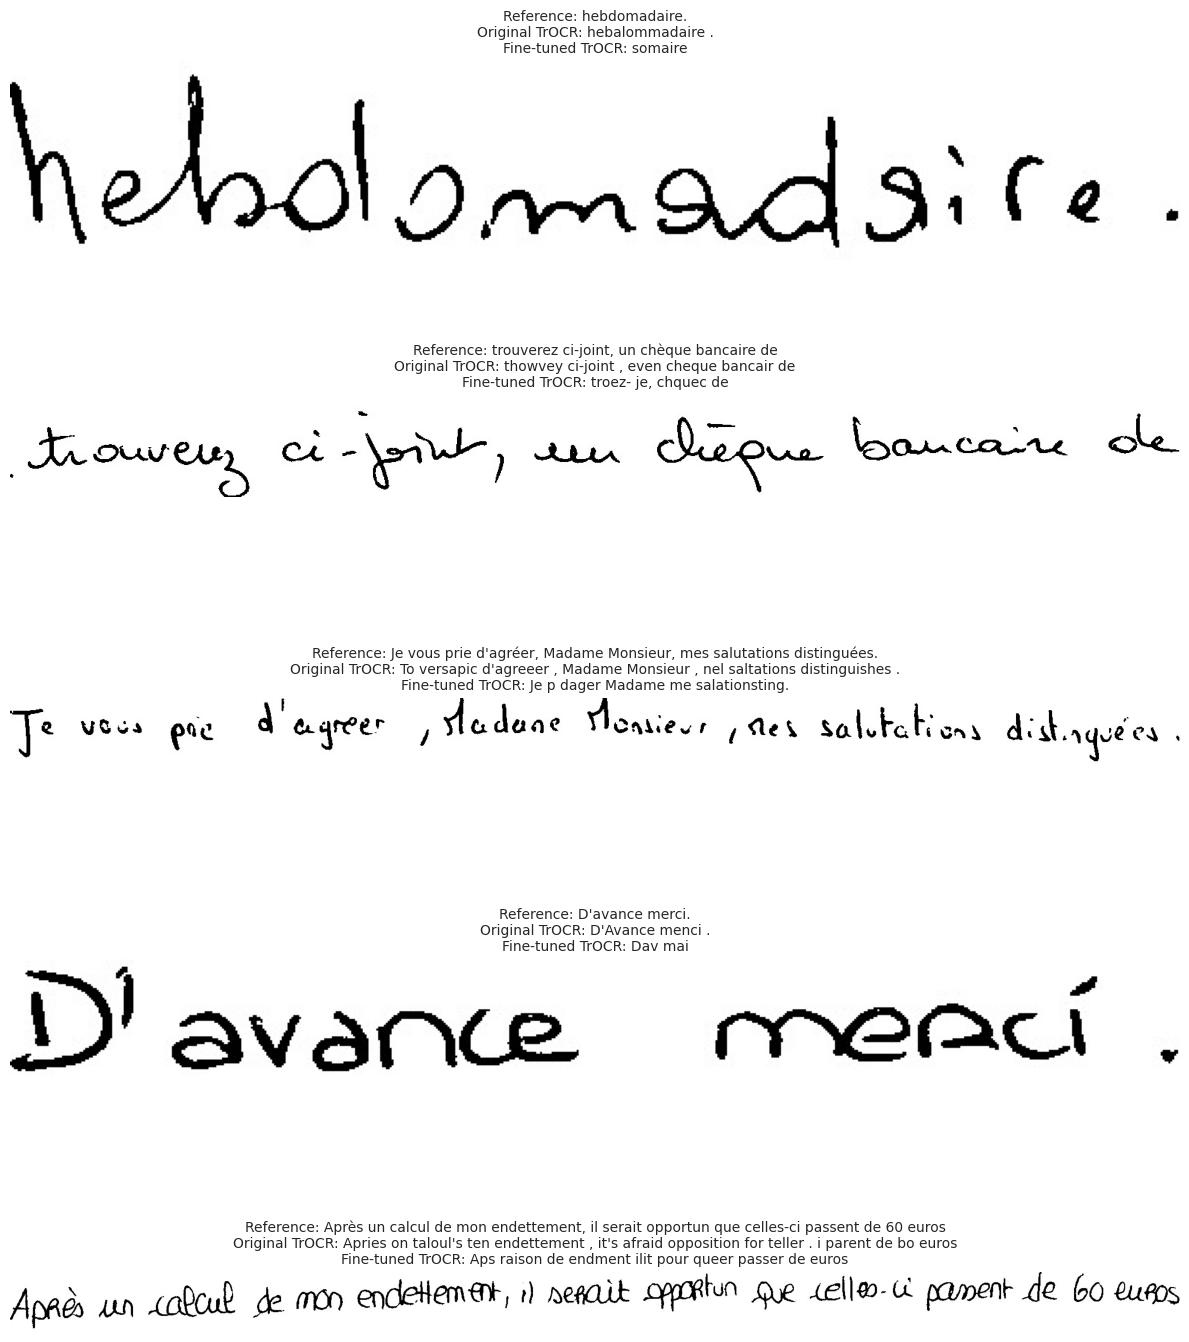

In [22]:
# === Visual comparison grid: Original vs Fine-tuned TrOCR ===
import matplotlib.pyplot as plt
from PIL import Image
import torch
from random import sample

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load models
orig_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-handwritten").to(device)
ft_model   = VisionEncoderDecoderModel.from_pretrained(trainer.args.output_dir).to(device)
orig_model.eval()
ft_model.eval()

# Convert HuggingFace validation dataset to list
val_list = list(dataset["validation"])

NUM_EXAMPLES = 5
examples = sample(val_list, NUM_EXAMPLES)

plt.figure(figsize=(12, NUM_EXAMPLES*3))

for idx, ex in enumerate(examples):
    # Use the original image path
    image_path = ex.get("image")  # safely get image
    if image_path is None:
        continue  # skip if no image

    image = Image.open(image_path).convert("RGB")
    pix = processor(image, return_tensors="pt").pixel_values.to(device)

    # Generate predictions
    with torch.no_grad():
        pred_orig_ids = orig_model.generate(pix, max_length=128)
        pred_ft_ids   = ft_model.generate(pix, max_length=128)

    pred_orig = processor.tokenizer.decode(pred_orig_ids[0], skip_special_tokens=True)
    pred_ft   = processor.tokenizer.decode(pred_ft_ids[0], skip_special_tokens=True)

    # Use the original text if present
    reference = ex.get("text") or processor.tokenizer.decode(ex.get("labels", []), skip_special_tokens=True)

    # Plot
    plt.subplot(NUM_EXAMPLES, 1, idx+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Reference: {reference}\nOriginal TrOCR: {pred_orig}\nFine-tuned TrOCR: {pred_ft}", fontsize=10)

plt.tight_layout()
plt.show()
